In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/"

# Folder with dataset time data csv's
folder = '/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/'



Mounted at /content/drive
/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition


# Initialisation


In [7]:
import sys
import os
# sys.path.append('/Users/Joe/opt/anaconda3/lib/python3.8/site-packages/ffmpeg')
import math
import sklearn
from sklearn.preprocessing import LabelEncoder, normalize
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM, Add, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Reshape, LeakyReLU, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D 
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.utils import to_categorical
import seaborn as sb
!pip install json_tricks
from json_tricks import dump, load

rs = 87

folder = "Features/TIME"
# -----------------------

## Set Params

In [8]:

fs = 16000

# Setting FFT params
Nfft = 512        # FFT Length
win_len_ms = 25   # Window Length in ms
hop_len_ms = 10   # Hop Size in ms

# Converting ms to samples
win_len = int((fs/1000) * win_len_ms)
hop_len = int((fs/1000) * hop_len_ms)

# Serialising params
dataset ='RAVDESS'
sr = str(fs)
# fts1 = 'Shifted_Noisey'
feature = "Shifted_Noisey"
feature_save_name = f"/{feature}_{dataset}_{sr}"
load_path = f"{folder}Features/TIME/{dataset}/{feature_save_name}.csv" 

# Creating path for X and y feature data tobe saved

out_path = f"{os.getcwd()}/Features/MFCC/"
if not os.path.exists(out_path):
    os.makedirs(out_path)




# API

A short list of helper functions to be used throughout the notebook

Feature Extraction

In [9]:
def get_mfcc(path, measurement, augmentation ,fs, Nfft, 
                       hop_length, chunksize =100, fmax = 8000, n_mfcc = 13):
  
  """
  path:  [str] save path for MFCC's

  measurement: [str] what labels to measure over: gender, polarity etc

  augmentation: [str] declaring which data is being converted, clean or other
  various augmentations

  fs: [int] sample rate

  Nfft: [int] size of fft

  hop_length: [int] fft hop length

  chunksize: [int] chunk size for reading time csv file

  fmax: [int] max frequency after mel scaling
  
  n_mfcc: [int] amount of coefficients desired
  """
  labels = []
  features = []
  actor_id = [] 
  aug = []
  i = 0
    
  for chunk in pd.read_csv(path, chunksize=chunksize):
    x_chunk = chunk.iloc[:, 8:] 
    j = 0
    while j < len(chunk.index):
            
        x = np.array(x_chunk)
        y = chunk[measurement]
        y = np.asarray(y)
        temp = x[j]
        np.nan_to_num(temp, nan=0)
        mfccs = librosa.feature.mfcc(y=temp, sr=fs, n_mfcc=n_mfcc, 
                                         hop_length=hop_length, n_fft = Nfft)

        features.append(mfccs)
        actor = chunk['Actor ID']  
        actor = np.asarray(actor)
        actor_id.append(actor[j]) 
        labels.append(f"{y[j]}_{feature}_{actor[j]}_{i}")
        j = j+1
        i = i+1
       
  if not os.path.exists(f"{out_path}/{dataset}/{feature}/"):
    os.makedirs(f"{out_path}/{dataset}/{feature}/")

  x = features
  y = labels
  X_path = f"{out_path}/{dataset}/{feature}/"
  y_path = f"{out_path}/{dataset}/{feature}/"
  X_name = f"{X_path}X_MFCC_{dataset}_{feature}_{sr}.json"
  y_name = f"{y_path}Y_MFCC_{dataset}_{feature}_{sr}.json"
  dump(x, X_name)
  dump(y, y_name)
            

prepare data


In [10]:
def normalise(X):

  ''' The function takes training data and returns normalised data'''
  mean = np.mean(X, axis = 0)
  std = np.std(X, axis = 0)
  X = (X - mean) / std
  X = np.nan_to_num(X)
  return X

def labler(y):
  ''' The function takes the full signal tag and creates new emotion 
      based labels '''
  y = pd.DataFrame(y, columns=['Tags'])
  y = y['Tags'].str.split('_').str[1]

  y = np.asarray(y)
  return y

Results

In [11]:
def get_results(model, X_test, y_test, lb):
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]*100
    print(("Test Accuracy: ", model.metrics_names[1], score[1]*100))
    predictions = model.predict(X_test, batch_size=16, verbose=1)
    predictions = predictions.argmax(axis=1)
    predictions = predictions.astype(int).flatten()
    predictions = (lb.inverse_transform(predictions))
    predictions = pd.DataFrame({'predicted': predictions})

    actual = y_test.argmax(axis=1)
    actual = actual.astype(int).flatten()
    actual = (lb.inverse_transform(actual))
    actual = pd.DataFrame({'actual': actual})

    results = actual.join(predictions)
    
    return results, accuracy


def create_confusion_matrix(Y, save_path , model_name , 
           title):
  classes = Y.actual.unique()
  classes.tolist()
  classes.sort()
  cm = confusion_matrix(Y.actual, Y.predicted)
  cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_df = pd.DataFrame(cm_n, index=classes, columns=classes)
  fig = plt.figure(figsize=(9,8))
  try:
          heatmap = sb.heatmap(cm_df, annot=True)
  except ValueError:
      raise ValueError('Confusion matrix values must be ints')

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
  plt.title(f"{title}")
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  save_name = f"{save_report} {title}.png"
  plt.savefig(f"{save_report} {title}.png" )
  plt.show()


# Feature Extraction

## Save Features

Save clean MFCC's

In [7]:

sr = str(fs)
augmentation = "Clean"
save_name = f"/{augmentation}_{dataset}_{sr}"
save_loc = f"{os.getcwd()}/{folder}/{dataset}{save_name}.csv" 

get_mfcc(save_loc,"Labels",feature, fs ,Nfft,hop_len, win_len, 200)


Save time shifted noisey MFCC's

In [ ]:

sr = str(fs)
augmentation = "Shifted_Noisey"
save_name = f"/{augmentation}_{dataset}_{sr}"
save_loc = f"{os.getcwd()}/{folder}/{dataset}{save_name}.csv" 

get_mfcc(save_loc,"Labels",feature, fs ,Nfft,hop_len, win_len, 200)

print(f"All images saved in: \n {save_loc}")

# Create Dataset

## Load feature arrays and labels

Load Train Data

In [12]:
X=[]
y=[]
test_X =[]
test_y = []
feature1 = "Clean"
feature2 = "Shifted_Noisey"
path = f"{out_path}{dataset}/{feature1}/"
featues_path = f"{path}X_MFCC_{dataset}_Clean_{sr}.json"
labels_path = f"{path}Y_MFCC_{dataset}_Clean_{sr}.json"

x_clean = load(featues_path)
x_clean = np.asarray(x_clean,dtype='float32' )
y_clean = load(labels_path)
y_clean = np.asarray(y_clean)

# Appending the clean data
for i in range(len(y_clean)):
  temp1 = y_clean[i].split('_')[0]
  temp2 = y_clean[i].split('_')[1]
  temp3 = y_clean[i].split('_')[3]

# Isolating speakers for speaker indpendence testing
  if temp3 == '1' or temp3 =='2':
      test_X.append(x_clean[i])
      test_y.append((f"{temp1}_{temp2}_{temp3}_Clean"))
  else:
      X.append(x_clean[i])
      y.append(f"{temp1}_{temp2}_{temp3}_Clean")

# Appending the augmented data
path = f"{out_path}{dataset}/{feature2}/"
featues_path = f"{path}X_MFCC_{dataset}_Shifted_Noisey_{sr}.json"
labels_path = f"{path}Y_MFCC_{dataset}_Shifted_Noisey_{sr}.json"
x_aug = load(featues_path)
x_aug = np.asarray(x_aug,dtype='float32' )
y_aug = load(labels_path)
y_aug = np.asarray(y_aug)


for i in range(len(y_clean)):
  temp1 = y_clean[i].split('_')[0]
  temp2 = y_clean[i].split('_')[1]
  temp3 = y_clean[i].split('_')[3]
  
  if temp3 == '1' or temp3 =='2':
      test_X.append(x_clean[i])
      test_y.append((f"{temp1}_{temp2}_{temp3}_Aug"))
  else:
      X.append(x_clean[i])
      y.append(f"{temp1}_{temp2}_{temp3}_Aug")


# Prepare Data

Here we finalsie the data for training within the network. The data is normalised, split in to train/valdiation/and testing data.


In [13]:
X_si_test = np.asarray(test_X)
y_si_test = np.asarray(test_y)

X = np.asarray(X)
y = np.asarray(y)

print(f"Shape of feature arrays: {X.shape}\n")
print(f"Shape of label arrays: {y.shape}\n")

# Vue label counts
# (unique, counts) = np.unique(y, return_counts=True)
# freq = np.asarray((unique,counts)).T
# print('Label Counts:\n\n', freq)

Shape of feature arrays: (2288, 13, 301)

Shape of label arrays: (2288,)



## Normalise

In [14]:
X = normalise(X)
X_si_test = normalise(X_si_test)


## Split data

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y, random_state=rs)

# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, shuffle=True, stratify=y, random_state=rs)
# X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle = True, stratify=y_rem, random_state=rs)

print(f"Train Size = {len(X_train)}")
print(f"Val Size = {len(X_val)}")
print(f"Speaker Independence Test Size = {len(X_si_test)}")

# Extract final label value
y_train = labler(y_train)
y_val = labler(y_val)
y_si_test = labler(y_si_test)



Train Size = 1830
Val Size = 458
Speaker Independence Test Size = 208


## Encode labels

One hot encoding for the final label values.

In [16]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.transform(y_val))
y_si_test = to_categorical(lb.transform(y_si_test))

# Model


## 1D CNN

### Params

In [65]:
model_name = 'CNN1D_MFCC_RAV_14'

model_name_save = model_name + '_weights'+'.h5'

num_fc = 64
batch_size = 16
num_classes = 6
num_epochs = 500 #best model will be saved before number of epochs reach this value
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9
input_shape = X_train.shape[1:3]
print(X_train.shape)

(1830, 13, 301)


### Callbacks

In [66]:
%%time

# Save best weights
cp_path = "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/Best_" + model_name_save
mcp_save = callbacks.ModelCheckpoint(cp_path)


# Reduce learning rate and stopping
reduce_LR = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=30)


CPU times: user 100 µs, sys: 0 ns, total: 100 µs
Wall time: 106 µs


### Architecture

In [67]:
def cnn1D(input_shape = input_shape, model_name = model_name):
  X_input = Input(input_shape)
  X = SpatialDropout1D(0.7)(X_input)

  X = Conv1D(128, 3, padding='same')(X)
  X = SpatialDropout1D(0.5)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv1D(128, 3, padding='same')(X)
  X = SpatialDropout1D(0.5)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling1D(pool_size=(2), strides=1, padding='same')(X)
  

  X = Bidirectional(LSTM(256, return_sequences=True))(X)
  X = Dropout(0.6)(X)

  # X = Bidirectional(LSTM(512))(X)
  # X = Dropout(0.5)(X)

  X = Dense(512)(X)
  X = Dropout(0.5)(X)
  # X = Dense(256)(X)
  # X = Dropout(0.5)(X)
  X = Flatten()(X)
  X = Dense(6)(X)
  X = Activation('softmax')(X)
 

  model = Model(inputs = X_input, outputs = X, name = model_name)
  return model

model = cnn1D()
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "CNN1D_MFCC_RAV_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 13, 301)]         0         
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 13, 301)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 128)           115712    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 13, 128)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_5 (Batc  (None, 13, 128)          512       
 hNormalization)                                                 
                                                 

### Train

In [68]:

model_history=model.fit(X_train, y_train, batch_size=batch_size, 
                        epochs=num_epochs, validation_data=(X_val, y_val),
                        callbacks=[reduce_LR, early_stop, mcp_save])

Epoch 1/500
115/115 [==============================] - 6s 18ms/step - loss: 1.9261 - accuracy: 0.1923 - val_loss: 1.7789 - val_accuracy: 0.2009 - lr: 1.0000e-04
Epoch 2/500
115/115 [==============================] - 1s 10ms/step - loss: 1.9031 - accuracy: 0.1995 - val_loss: 1.7770 - val_accuracy: 0.2445 - lr: 1.0000e-04
Epoch 3/500
115/115 [==============================] - 1s 10ms/step - loss: 1.8590 - accuracy: 0.2126 - val_loss: 1.7701 - val_accuracy: 0.2271 - lr: 1.0000e-04
Epoch 4/500
115/115 [==============================] - 1s 10ms/step - loss: 1.8688 - accuracy: 0.1973 - val_loss: 1.7693 - val_accuracy: 0.2336 - lr: 1.0000e-04
Epoch 5/500
115/115 [==============================] - 1s 10ms/step - loss: 1.8035 - accuracy: 0.2311 - val_loss: 1.7591 - val_accuracy: 0.2293 - lr: 1.0000e-04
Epoch 6/500
115/115 [==============================] - 1s 10ms/step - loss: 1.8249 - accuracy: 0.2191 - val_loss: 1.7461 - val_accuracy: 0.2424 - lr: 1.0000e-04
Epoch 7/500
115/115 [=============

### Serialize

In [69]:
name = model_name_save
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, name)
model.save(model_path)

print('Save model and weights at %s ' % model_path)

model_json = model.to_json()
with open('saved_models/' + model_name, "w") as json_file:
    json_file.write(model_json)


Save model and weights at /content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/CNN1D_MFCC_RAV_14_weights.h5 


# Reports

Assesing the models accuracy for speaker dependent and independent emotion detection. 

Load Model

In [70]:
model_path = "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/"+model_name
weights_path = "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/Best_"+ model_name_save

json_model = open(model_path, 'r')
loaded_model = json_model.read()
json_model.close()
loaded_model = model_from_json(loaded_model)
loaded_model.load_weights(weights_path)

Accuracy and Loss

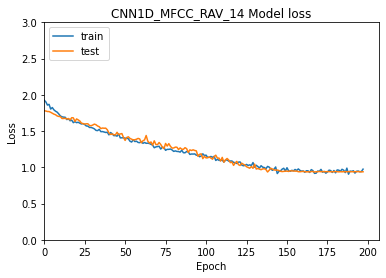

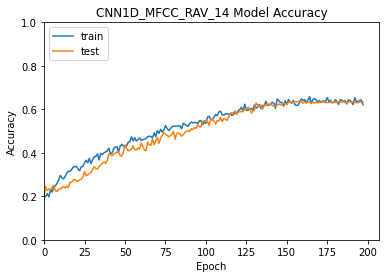

In [71]:
save_report = f"/content/drive/MyDrive/Colaboratory/SERv2/REPORTS/{model_name}/"
if not os.path.isdir(save_report):
    os.makedirs(save_report)

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title(model_name + ' Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0)
plt.ylim(0, 3)
plt.legend(['train', 'test'], loc='upper left')
save_name = f"{save_report}Model Training Loss.png"
plt.savefig(save_name)

plt.show()


plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title(model_name + ' Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0)
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
save_name = f"{save_report}Model Training Accuracy.png"
plt.savefig(save_name)



In [72]:
model.summary()
save_report = f"{os.getcwd()}/REPORTS/{model_name}/"
if not os.path.isdir(save_report):
    os.makedirs(save_report)
with open(f"{save_report} Summary.txt", 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "CNN1D_MFCC_RAV_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 13, 301)]         0         
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 13, 301)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 128)           115712    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 13, 128)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_5 (Batc  (None, 13, 128)          512       
 hNormalization)                                                 
                                                 



Classification Results

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])





('Test Accuracy: ', 'accuracy', 63.318777084350586)
29/29 [==============================] - 1s 4ms/step


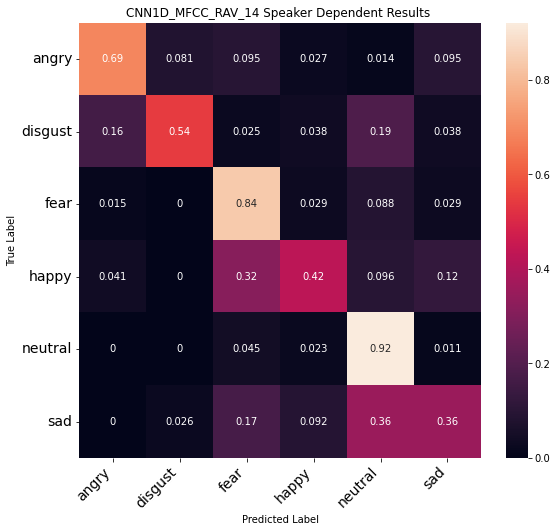

{'angry': {'precision': 0.75, 'recall': 0.6891891891891891, 'f1-score': 0.7183098591549296, 'support': 74}, 'disgust': {'precision': 0.8431372549019608, 'recall': 0.5443037974683544, 'f1-score': 0.6615384615384615, 'support': 79}, 'fear': {'precision': 0.5377358490566038, 'recall': 0.8382352941176471, 'f1-score': 0.6551724137931034, 'support': 68}, 'happy': {'precision': 0.6595744680851063, 'recall': 0.4246575342465753, 'f1-score': 0.5166666666666666, 'support': 73}, 'neutral': {'precision': 0.5912408759124088, 'recall': 0.9204545454545454, 'f1-score': 0.72, 'support': 88}, 'sad': {'precision': 0.5510204081632653, 'recall': 0.35526315789473684, 'f1-score': 0.432, 'support': 76}, 'accuracy': 0.6331877729257642, 'macro avg': {'precision': 0.6554514760198908, 'recall': 0.628683919728508, 'f1-score': 0.6172812335255269, 'support': 458}, 'weighted avg': {'precision': 0.6566147710568054, 'recall': 0.6331877729257642, 'f1-score': 0.6198184690908317, 'support': 458}}


In [74]:
predictions, sd_acc = get_results(model = loaded_model, X_test = X_val, 
                      y_test = y_val, lb=lb)
# print(type(results))


create_confusion_matrix(Y=predictions, save_path = save_report, model_name = model_name, 
           title=f"{model_name} Speaker Dependent Results ")

classes = predictions.actual.unique()
classes.sort()
report = classification_report(predictions.actual, predictions.predicted, target_names=classes, output_dict=True, digits=3)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{save_report} Speaker Dependence Accuracy.csv")
print(report)


('Test Accuracy: ', 'accuracy', 48.076921701431274)
13/13 [==============================] - 1s 4ms/step


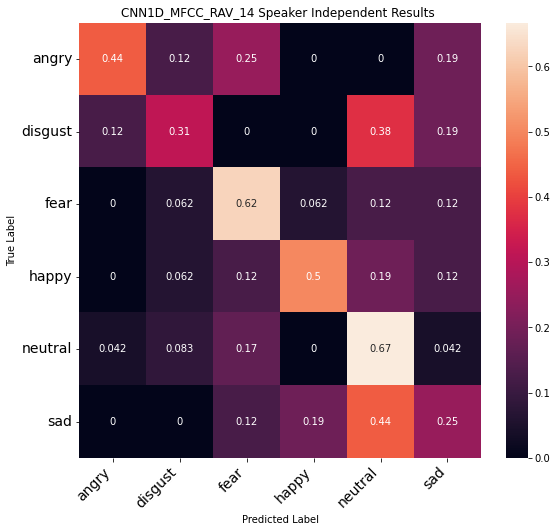

{'angry': {'precision': 0.7, 'recall': 0.4375, 'f1-score': 0.5384615384615384, 'support': 32}, 'disgust': {'precision': 0.45454545454545453, 'recall': 0.3125, 'f1-score': 0.3703703703703703, 'support': 32}, 'fear': {'precision': 0.45454545454545453, 'recall': 0.625, 'f1-score': 0.5263157894736842, 'support': 32}, 'happy': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1-score': 0.5714285714285715, 'support': 32}, 'neutral': {'precision': 0.47058823529411764, 'recall': 0.6666666666666666, 'f1-score': 0.5517241379310345, 'support': 48}, 'sad': {'precision': 0.26666666666666666, 'recall': 0.25, 'f1-score': 0.2580645161290323, 'support': 32}, 'accuracy': 0.4807692307692308, 'macro avg': {'precision': 0.5021687462863934, 'recall': 0.46527777777777773, 'f1-score': 0.46939415396570533, 'support': 208}, 'weighted avg': {'precision': 0.4997394762100644, 'recall': 0.4807692307692308, 'f1-score': 0.475727229655346, 'support': 208}}


In [75]:
predictions, si_acc = get_results(model = loaded_model, X_test = X_si_test, 
                      y_test = y_si_test, lb=lb)
# print(type(results))

create_confusion_matrix(Y=predictions, save_path = save_report, model_name = model_name, 
           title=f"{model_name} Speaker Independent Results ")


classes = predictions.actual.unique()
classes.sort()
report = classification_report(predictions.actual, predictions.predicted, target_names=classes, output_dict=True, digits=3)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{save_report}  Speaker Indpendence Accuracy.csv")
print(report)

### Saving recurrent results

This code saves the accuracy for both metrics to a running excel spreadsheet for easy access to high performing model details

In [76]:

from openpyxl import load_workbook

df = pd.DataFrame({'Name': [model_name],
                   'Speaker Dependent': [sd_acc], 
                   'Speaker Independent': [si_acc]})
writer = pd.ExcelWriter('SER_Model_Accuracy_1DMFCC.xlsx', engine='openpyxl')

# df.to_excel(writer, sheet_name='Sheet1', index=False)
# writer.save()

writer.book = load_workbook('SER_Model_Accuracy_1DMFCC.xlsx')
# copy existing sheets
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
# read existing file
reader = pd.read_excel(r'SER_Model_Accuracy_1DMFCC.xlsx')
# write out the new sheet
df.to_excel(writer,index=False,header=False,startrow=len(reader)+1)
writer.close()
